In [16]:
import numpy as np
from medmnist import INFO
import matplotlib.pyplot as plt
import tensorflow as tf
import dataset_without_pytorch

from dataset_without_pytorch import get_loader
from tensorflow.keras import losses

from keras.layers import Input, Conv2D, MaxPooling2D , UpSampling2D, add, Input
from keras.models import Model
from keras import regularizers

from skimage.io import imshow

In [3]:
data_flag = 'pneumoniamnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(dataset_without_pytorch, info['python_class'])

In [4]:
# load the data
train_dataset = DataClass(split = 'train', download = download, size = 128, root = '/Users/ciswhitemale/.medmnist/')
test_dataset = DataClass(split = 'test', download = download, size = 128)
val_dataset = DataClass(split = 'val', download = download, size = 128)


# encapsulate data into dataloader form
train_loader = get_loader(dataset=train_dataset, batch_size=BATCH_SIZE)
test_loader = get_loader(dataset = test_dataset, batch_size=BATCH_SIZE)

Using downloaded and verified file: /Users/ciswhitemale/.medmnist/pneumoniamnist_128.npz
Using downloaded and verified file: /Users/ciswhitemale/.medmnist/pneumoniamnist_128.npz
Using downloaded and verified file: /Users/ciswhitemale/.medmnist/pneumoniamnist_128.npz


In [5]:
train_file = np.load('/Users/ciswhitemale/.medmnist/pneumoniamnist_128.npz')

x_train = train_file['train_images']
x_test = train_file['test_images']
x_val = train_file['val_images']
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_val=x_val.astype('float32') / 255.

print (x_val.shape)
print (x_test.shape)

(524, 128, 128)
(624, 128, 128)


In [10]:
noise_factor = 0.2

x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)
x_val_noisy = x_val + noise_factor * tf.random.normal(shape=x_val.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)
x_val_noisy = tf.clip_by_value(x_val_noisy, clip_value_min=0., clip_value_max=1.)


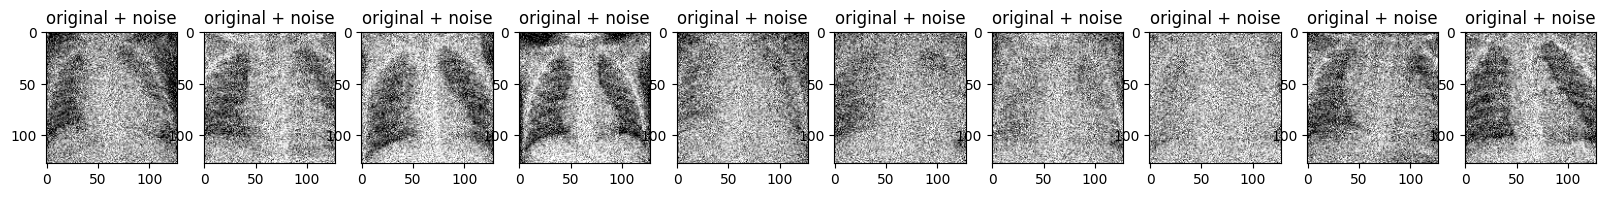

In [11]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [14]:
# Encoder

n = 128
chan = 1
input_img = Input(shape=(n, n, chan))

l1 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = MaxPooling2D(padding='same')(l2)
l4 = Conv2D(64, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)

# Decoder

l7 = UpSampling2D()(l6)
l8 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),)(l7)
l9 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = add([l5, l9])
l11 = UpSampling2D()(l10)
l12 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l11)
l13 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = add([l13, l2])

# chan = 3, for RGB
decoded = Conv2D(chan, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l14)

# Create our network
autoencoder = Model(input_img, decoded)
# You'll understand later what this is

autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     36,928 │ up_sampling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ conv2d_3[0][0],   │
│                     │ 64)               │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │     18,464 │ up_sampling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128,  │          0 │ conv2d_7[0][0],   │
│                     │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │        289 │ add_1[0][0]       │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 166,849 (651.75 KB)

 Trainable params: 166,849 (651.75 KB)

 Non-trainable params: 0 (0.00 B)

tuner.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
best_model = tuner.get_best_models()[0]

In [10]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=losses.MeanSquaredError())
# autoencoder.fit(x_train_noisy, x_train,epochs=25,batch_size = 16,shuffle=True, validation_data=(x_test_noisy, x_test))

In [11]:
ori_weights = autoencoder.get_weights()

/var/folders/tf/j4q2snk50tqd8r7zkdzp3q1h0000gn/T/ipykernel_4544/3380963639.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(x_val[1])


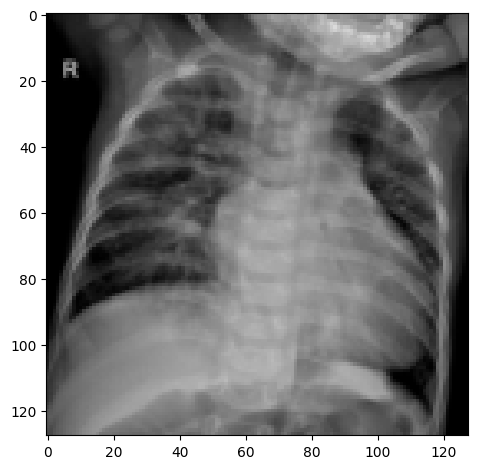

In [17]:
imshow(x_val[1])

In [18]:
decoded_imgs=autoencoder.predict(x_val_noisy)

 3/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 

2025-02-17 10:52:07.571631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


/var/folders/tf/j4q2snk50tqd8r7zkdzp3q1h0000gn/T/ipykernel_4544/79628611.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(decoded_imgs[1])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


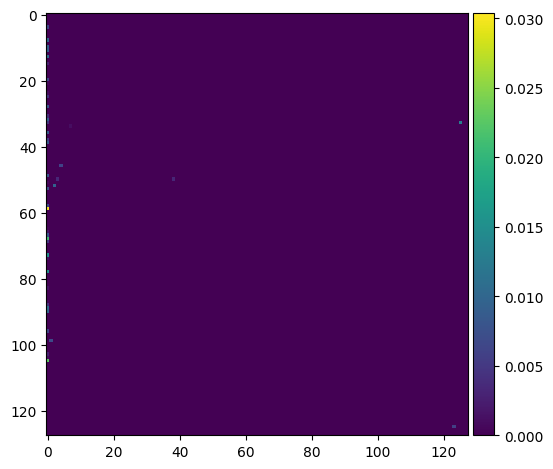

In [19]:
imshow(decoded_imgs[1])

In [15]:
# encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
# decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [20]:
def mse(orig, res):
    return ((orig - res) ** 2).mean()
     

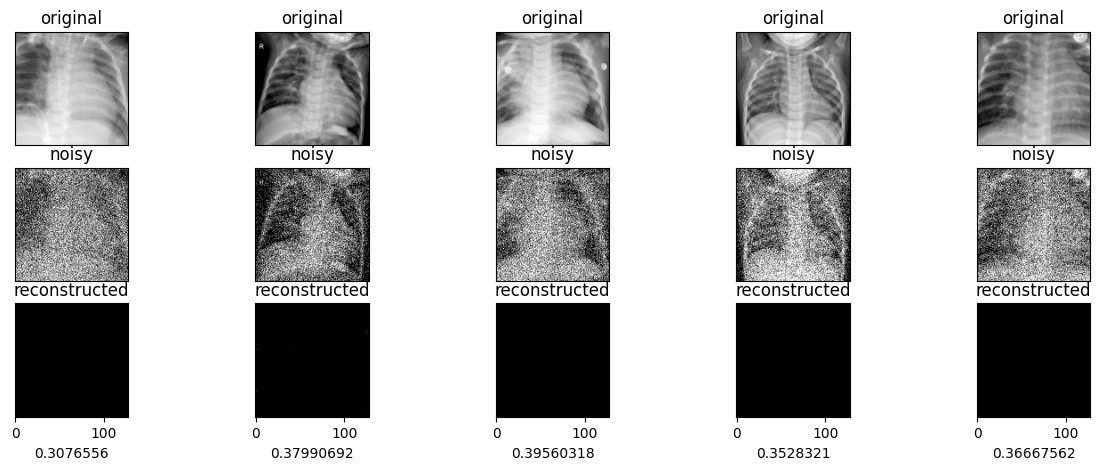

In [21]:
n = 5
plt.figure(figsize=(15, 5))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_val[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_val_noisy[i])
    plt.title("noisy")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(True)
    plt.xlabel(mse(x_test[i], decoded_imgs[i]))
    ax.get_yaxis().set_visible(False)

plt.show()

/var/folders/tf/j4q2snk50tqd8r7zkdzp3q1h0000gn/T/ipykernel_4544/2126481622.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(decoded_imgs[2])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


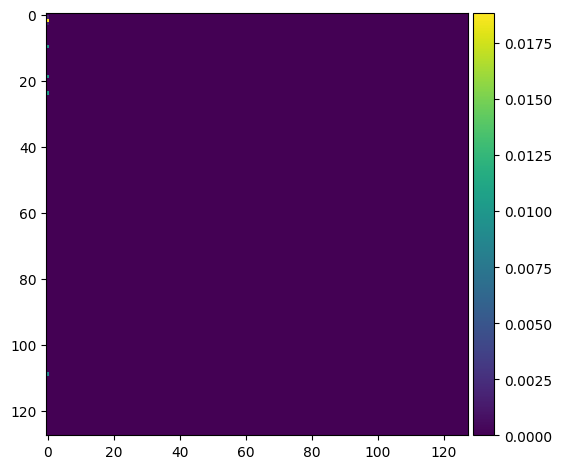

In [22]:
imshow(decoded_imgs[2])

# multiple "networks"

1) 50/50 netværk 
2) 4* 25 netværk
3) 10 * 10 netværk

planen er at træne det her netværk seperat og bruge noget magic til at sætte vægtene sammen til et netværk og så evaluerer dem mod det fulde netværk 

Vi kører alle netværk ved 25 epoker. 

In [26]:
def setup_model():
    n = 128
    chan = 1
    input_img = Input(shape=(n, n, chan))

    l1 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)
    l2 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)
    l3 = MaxPooling2D(padding='same')(l2)
    #l3 = Dropout(0.3)(l3)
    l4 = Conv2D(64, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
    l5 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)
    l6 = MaxPooling2D(padding='same')(l5)

    # Decoder

    l8 = UpSampling2D()(l6)

    l9 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10),)(l8)
    l10 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l9)

    l11 = add([l5, l10])
    l12 = UpSampling2D()(l11)
    #l3 = Dropout(0.3)(l3)
    l13 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l12)
    l14 = Conv2D(32, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l13)

    l15 = add([l14, l2])

    # chan = 3, for RGB
    decoded = Conv2D(chan, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l15)

    return Model(input_img, decoded)

In [27]:
def generate_noise(data, noise_factor = 0.2):
    return data + noise_factor * tf.random.normal(shape=data.shape)

In [28]:
def split_data(data, n, noise_factor = 0.2):
    m = len(data)
    clean_split = []
    for i in range(n):
        clean_split.append(data[m * i // n: m * (i + 1) // n])
    noisy_split = [generate_noise(x, noise_factor) for x in clean_split]
    return clean_split, noisy_split

In [30]:
def run_model(n, epochs):
    # Make overall model
    autoencoder = setup_model()
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=losses.MeanSquaredError())

    # Make n models
    models = [setup_model() for _ in range(n)]
    for model in models:
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=losses.MeanSquaredError())

    # Split data
    train, train_noisy = split_data(x_train, n)
    test, test_noisy = split_data(x_test, n)

    # Get central weights
    primary_weights = models[0].get_weights()
    for model in models:
        model.set_weights(primary_weights)
    
    # Train the networks
    for epoch in range(epochs):
        for i, model in enumerate(models):
            print(f"Encoder {i + 1}")
            model.fit(train_noisy[i], train[i], batch_size=32, epochs=1, shuffle=True, validation_data=(test_noisy[i], test[i]))
        weights = [model.get_weights() for model in models]
        weight_update = [0 for _ in primary_weights]
        for weight in weights:
            weight_update = [wu + (w - w0) / n for wu, w, w0 in zip(weight_update, weight, primary_weights)]
        primary_weights = [w0 + wu for w0, wu in zip(primary_weights, weight_update)]
        for model in models:
            model.set_weights(primary_weights)
        print(f"Epoch {epoch + 1} completed")
        print("")
    
    autoencoder.set_weights(primary_weights)
    return autoencoder

In [31]:
autoencoder = run_model(5, 5)

Encoder 1
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 0.0861 - val_loss: 0.0161
Encoder 2
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 0.0880 - val_loss: 0.0158
Encoder 3
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 0.0870 - val_loss: 0.0157
Encoder 4
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 0.0854 - val_loss: 0.0162
Encoder 5
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 0.0886 - val_loss: 0.0163
Epoch 1 completed

Encoder 1
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 0.0143 - val_loss: 0.0113
Encoder 2
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 0.0146 - val_loss: 0.0112
Encoder 3
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 0.0143 - val_loss: 0.0110
Encoder 4
30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 0.0141 - val_loss: 0.0112
Encoder 5
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 0.0144 - val_loss: 0.0112
Epoch 2 completed

Encoder 1
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 0.0104 - val_loss: 0.0085
Encoder 2
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step 

In [32]:
decoded_imgs=autoencoder.predict(x_val_noisy)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


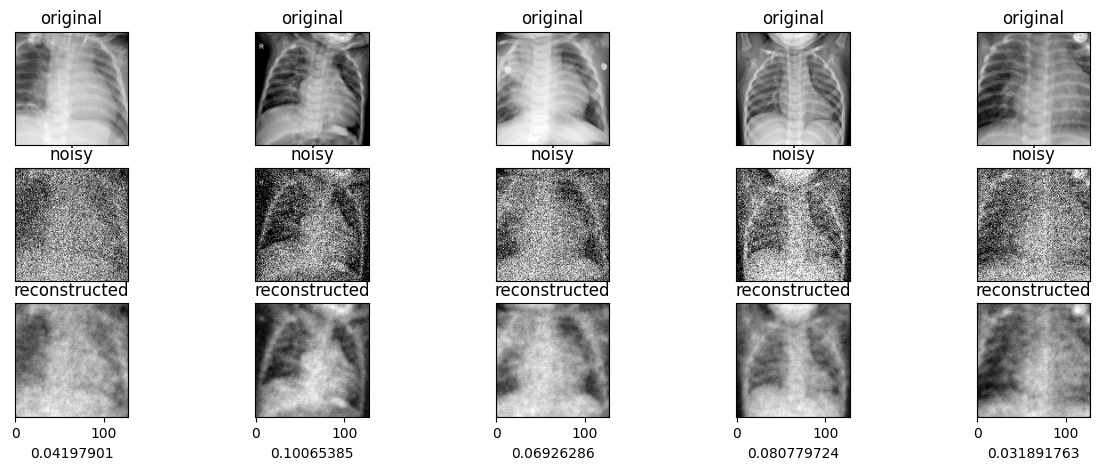

In [33]:
n = 5
plt.figure(figsize=(15, 5))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_val[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_val_noisy[i])
    plt.title("noisy")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(True)
    plt.xlabel(mse(x_test[i], decoded_imgs[i]))
    ax.get_yaxis().set_visible(False)

plt.show()